<font size=7> Latencies Analysis

In [10]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, read_phy_files
from human_hip.animate import animate_latencies

import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np

In [11]:
sd = read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_base.zip")

<font color="red"> We save curated latency pairs because above calculation took overt 10 minutes.

In [4]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc


def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=30, sttc_cutoff = 0.04, latency_cutoff=2.5, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
        if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                    pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 

    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    ##Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
        max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
        cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
    cross_lag = np.array(cross_lag)
    to_keep = np.where(( cross_lag< cross_sttc_max_cutoff) & (cross_lag> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 

In [5]:
good_pairs = curate_latencies(sd)

2601 Starting Pairs
567 pairs above sttc cutoff
50 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
14 pairs between cross_sttc cutoffs


In [5]:
# good_pairs = curate_latencies(sd)
# with open( 'chip21769_no_drug_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
##load pickled data
# with open( 'curate_latencies_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)
# len(good_pairs)

2601 Starting Pairs
567 pairs above sttc cutoff
50 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
14 pairs between cross_sttc cutoffs


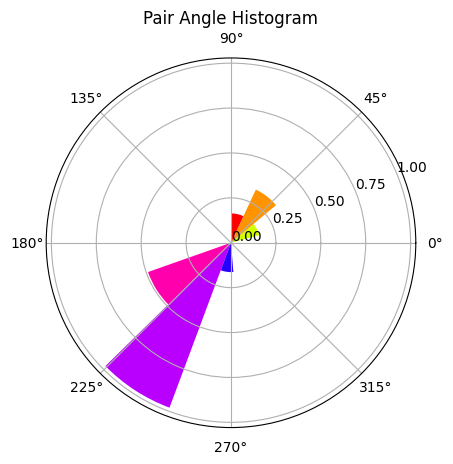

In [6]:
plot_latency_angle_hist( sd, good_pairs)

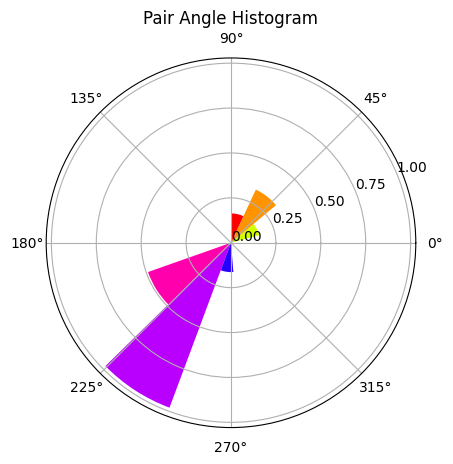

In [7]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=False)

In [8]:
plot_cross_sttc_pairs( sd, good_pairs )

interactive(children=(IntSlider(value=6, description='num', max=13), Button(description='Run Interact', style=…

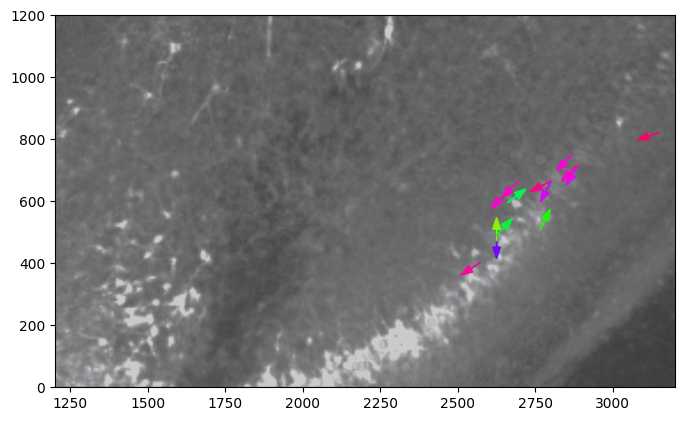

In [9]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200))

In [13]:
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
from scipy import stats

def pairs_hisogram(pairs, sd, ms_cutoff_high=30):
    @interact
    def plot_pair(pair_i = (0, len(pairs)-1) ):
        latencies_pair = latencies( pairs[pair_i,0], pairs[pair_i,1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )

pairs_hisogram( good_pairs, sd, ms_cutoff_high=30)

interactive(children=(IntSlider(value=6, description='pair_i', max=13), Output()), _dom_classes=('widget-inter…

# <font color="brown"> Figure Plot

In [9]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual
from matplotlib.ticker import MaxNLocator
import numpy as np

In [8]:

def plot_vector_layout2( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # organize pair directions
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=ms_cutoff_high))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key].append( angles[i] )
        else:
            pair_dict[key] = [ angles[i] ]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)


    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2
        #angle2 = (angle2 + .5) % 1

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)

In [8]:
plot_vector_layout2( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200))

NameError: name 'plot_vector_layout2' is not defined

# Vector Plots

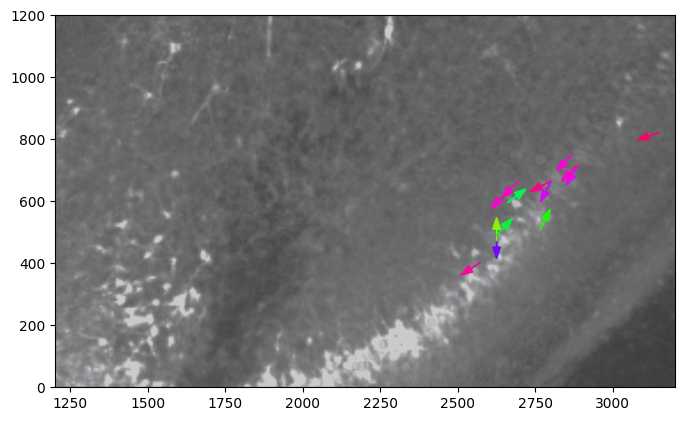

In [10]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200))

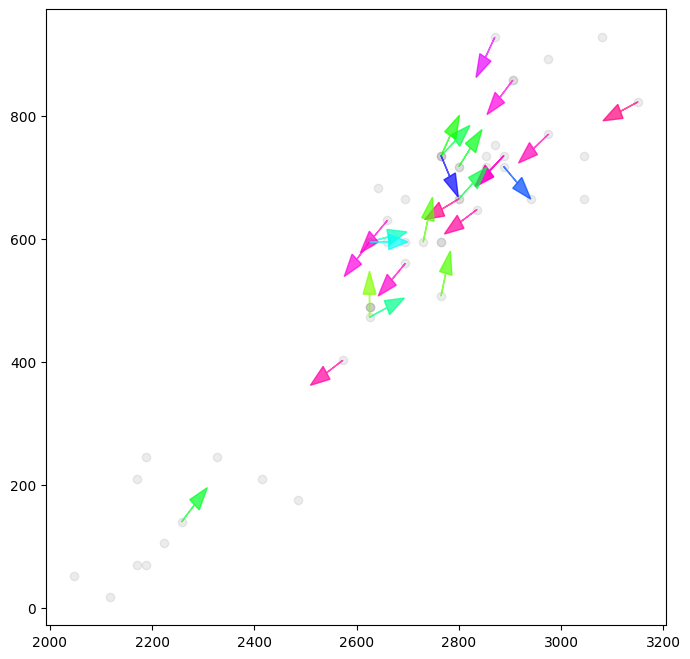

In [9]:
plot_vector_layout( sd, good_pairs)

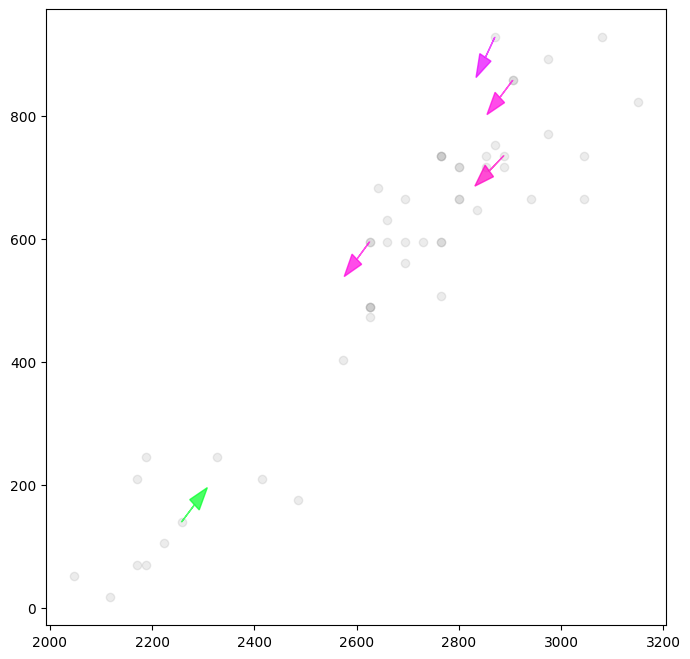

In [10]:
plot_vector_layout( sd, good_pairs, min_dist=500 )

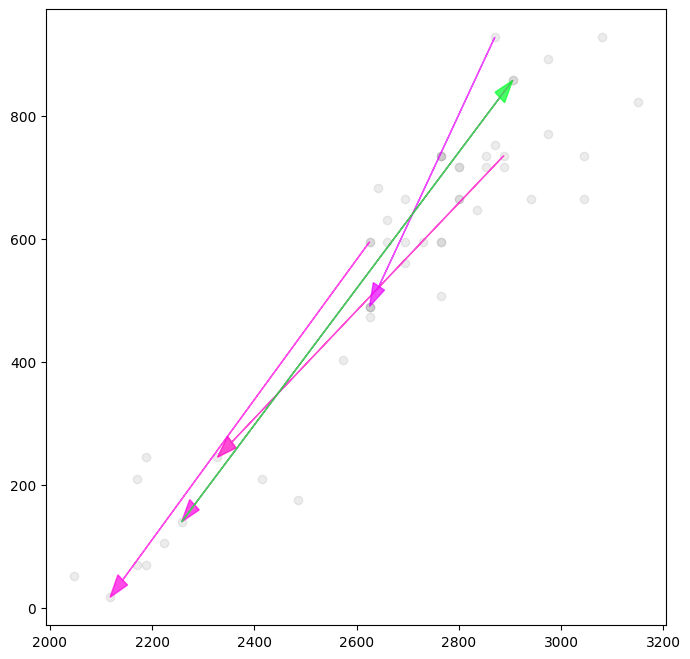

In [11]:
plot_vector_layout( sd, good_pairs, min_dist=500, normalize=False )